# Special Topics: Gaussian Processes

### 15th December 2015 Neil D. Lawrence

Over the last two sessions we've begun considering classification models and logistic regresssion. In particular, for naive Bayes, we considered a set of assumptions that allowed us to build a joint model of our data set. In particular for naive Bayes we specified 

1. Data conditional independence.
2. Feature conditional independence.
3. Marginal likelihood of labels was Bernoulli distributed.

This allowed us to specify the joint density of our labels and our input data, $p(\mathbf{y}, \mathbf{X}|\boldsymbol{\theta})$. And we conditioned on the training data to make predictions about the test data. 

## Generalized Linear Models 

Logistic regression is part of a wider class of models known as *generalized linear models*. In these models we determine that some characteristic of the model is speicified by a function that is liniear in the parameters. So we might suggest that
$$
\log \frac{p(\mathbf{x})}{1-p(\mathbf{x})} = f(\mathbf{x}; \mathbf{w})
$$
where $f(\mathbf{x}; \mathbf{w})$ is a linear-in-the-parameters function (here the parameters are $\mathbf{w}$, which is generally non-linear in the inputs. So far we have considered basis function models of the form
$$
f(\mathbf{x}) = \mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}).
$$

## Gaussian Processes

When we form a Gaussian process we do something that is slightly more akin to the naive Bayes approach, but actually is closely related to the generalized linear model approach. Models where we model the entire joint distribution of our training data, $p(\mathbf{y}, \mathbf{X})$ are sometimes described as *generative models*. Because we can use sampling to generate data sets that represent all our assumptions. However, as we discussed in the sessions on logistic regression and naive Bayes, this can be a bad idea, because if our assumptions are wrong then we can make poor predictions. We can try to make more complex assumptions about data to alleviate the problem, but then this typically leads to challenges for tractable application of the sum  and rules of probability that are needed to compute the relevant marginal and conditional densities. If we know the form of the question we wish to answer then we typically try and represent that directly, through $p(\mathbf{y}|\mathbf{X})$. In practice, we also have been making assumptions of conditional independence given the model parameters, 
$$
p(\mathbf{y}|\mathbf{X}, \mathbf{w}) = \prod_{i=1}^{n} p(y_i | \mathbf{x}_i, \mathbf{w})
$$
Gaussian processes are *not* normally considered to be *generative models*, but we will be much more interested in the principles of conditioning in Gaussian processes because we will use conditioning to make predictions between our test and training data. We will avoid the data conditional indpendence assumption in favour of a richer assumption about the data, in a Gaussian process we assume data is *jointly Gaussian* with a particular mean and covariance,
$$
\mathbf{y}|\mathbf{X} \sim \mathcal{N}(\mathbf{m}(\mathbf{X}), \mathbf{K}(\mathbf{X})),
$$
where the conditioning is on the inputs $\mathbf{X}$ which are used for computing the mean and covariance. For this reason they are known as mean and covariance functions.


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

## Marginal Likelihood

To understand the Gaussian process we're going to build on our understanding of the marginal likelihood for Bayesian regression. In the session on [Bayesian regression](./week7.ipynb) we sampled directly from the weight vector, $\mathbf{w}$ and applied it to the basis matrix $\boldsymbol{\Phi}$ to obtain a sample from the prior and a sample from the posterior. It is often helpful to think of modeling techniques as *generative* models. To give some thought as to what the process for obtaining data from the model is. From the perspective of Gaussian processes, we want to start by thinking of basis function models, where the parameters are sampled from a prior, but move to thinking about sampling from the marginal likelihood directly.

## Sampling from the Prior

The first thing we'll do is to set up the parameters of the model, these include the parameters of the prior, the parameters of the basis functions and the noise level. 

In [2]:
# set prior variance on w
alpha = 4.
# set the order of the polynomial basis set
degree = 5
# set the noise variance
sigma2 = 0.01

Now we have the variance, we can sample from the prior distribution to see what form we are imposing on the functions *a priori*. 


Let's now compute a range of values to make predictions at, spanning the *new* space of inputs,

In [3]:
def polynomial(x, degree, loc, scale):
    degrees = np.arange(degree+1)
    return ((x-loc)/scale)**degrees

now let's build the basis matrices. First we load in the data


In [4]:
import pods
data = pods.datasets.olympic_marathon_men()
x = data['X']
y = data['Y']

In [5]:
loc = 1950.
scale = 100.
num_data = x.shape[0]
num_pred_data = 100 # how many points to use for plotting predictions
x_pred = np.linspace(1880, 2030, num_pred_data)[:, None] # input locations for predictions
Phi_pred = polynomial(x_pred, degree=degree, loc=loc, scale=scale)
Phi = polynomial(x, degree=degree, loc=loc, scale=scale)

### Weight Space View

To generate typical functional predictions from the model, we need a set of model parameters. We assume that the parameters are drawn independently from a Gaussian density,
$$
\mathbf{w} \sim \mathcal{N}(\mathbf{0}, \alpha\mathbf{I}),
$$
then we can combine this with the definition of our prediction function $f(\mathbf{x})$,
$$
f(\mathbf{x}) = \mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}).
$$
We can now sample from the prior density to obtain a vector $\mathbf{w}$ using the function `np.random.normal` and combine these parameters with our basis to create some samples of what $f(\mathbf{x})$ looks like,

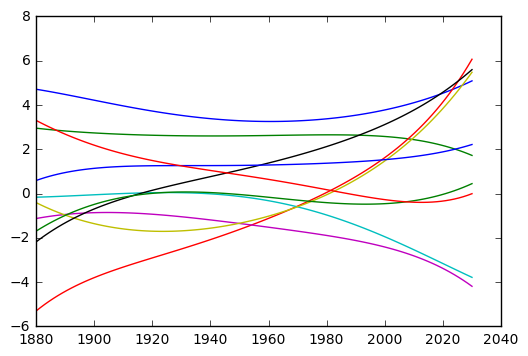

In [6]:
num_samples = 10
K = degree+1
for i in range(num_samples):
    z_vec = np.random.normal(size=(K, 1))
    w_sample = z_vec*np.sqrt(alpha)
    f_sample = np.dot(Phi_pred,w_sample)
    plt.plot(x_pred, f_sample)


### Function Space View

The process we have used to generate the samples is a two stage process. To obtain each function, we first generated a sample from the prior,
$$
\mathbf{w} \sim \mathcal{N}(\mathbf{0}, \alpha \mathbf{I})
$$
then if we compose our basis matrix, $\boldsymbol{\Phi}$ from the basis functions associated with each row then we get,
$$
\mathbf{\Phi} = \begin{bmatrix}\boldsymbol{\phi}(\mathbf{x}_1) \\ \vdots \\ \boldsymbol{\phi}(\mathbf{x}_n)\end{bmatrix}
$$
then we can write down the vector of function values, as evaluated at
$$
\mathbf{f} = \begin{bmatrix} f_1 \\ \vdots f_n\end{bmatrix}
$$
in the form
$$
\mathbf{f} = \boldsymbol{\Phi} \mathbf{w}.
$$

Now we can use standard properties of multivariate Gaussians to write down the probability density that is implied over $\mathbf{f}$. In particular we know that if $\mathbf{w}$ is sampled from a multivariate normal (or multivariate Gaussian) with covariance $\alpha \mathbf{I}$ and zero mean, then assuming that $\boldsymbol{\Phi}$ is a deterministic matrix (i.e. it is not sampled from a probability density) then the vector $\mathbf{f}$ will also be distributed according to a zero mean multivariate normal as follows,
$$
\mathbf{f} \sim \mathcal{N}(\mathbf{0},\alpha \boldsymbol{\Phi} \boldsymbol{\Phi}^\top).
$$

The question now is, what happens if we sample $\mathbf{f}$ directly from this density, rather than first sampling $\mathbf{w}$ and then multiplying by $\boldsymbol{\Phi}$. Let's try this. First of all we define the covariance as
$$
\mathbf{K} = \alpha \boldsymbol{\Phi}\boldsymbol{\Phi}^\top.
$$

In [7]:
K = alpha*np.dot(Phi_pred, Phi_pred.T)

Now we can use the `np.random.multivariate_normal` command for sampling from a  multivariate normal with covariance given by $\mathbf{K}$ and zero mean,

/Users/neil/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  from ipykernel import kernelapp as app


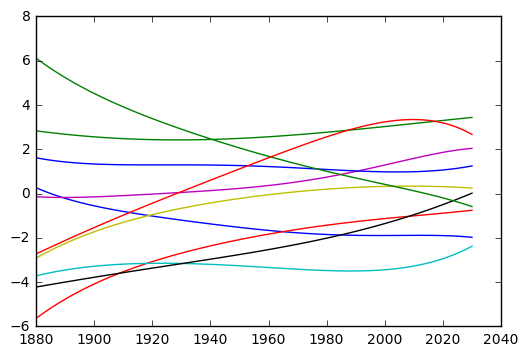

In [8]:
for i in np.arange(10):
    f_sample = np.random.multivariate_normal(mean=np.zeros(x_pred.size), cov=K)
    plt.plot(x_pred.flatten(), f_sample.flatten())

The samples appear very similar to those which we obtained indirectly. That is no surprise because they are effectively drawn from the same mutivariate normal density. However, when sampling $\mathbf{f}$ directly we created the covariance for $\mathbf{f}$. We can visualise the form of this covaraince in an image in python with a colorbar to show scale.

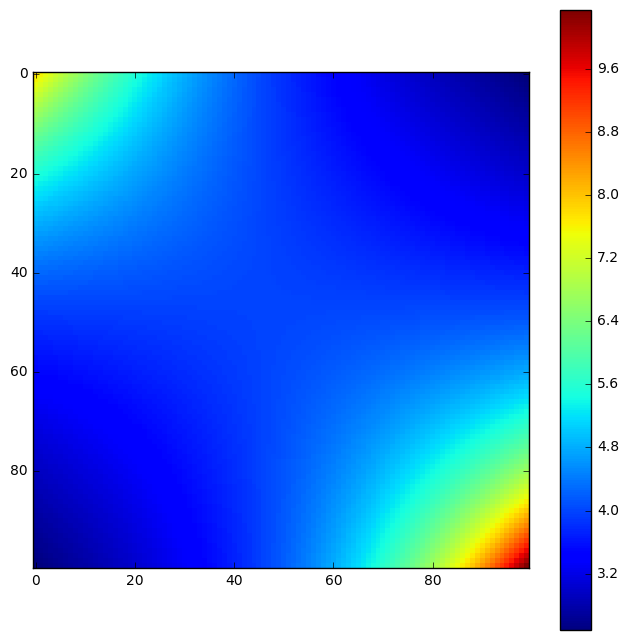

In [9]:
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(K, interpolation='none')
fig.colorbar(im)

This image is the covariance expressed between different points on the function. In regression we normally also add independent Gaussian noise to obtain our observations $\mathbf{y}$,
$$
\mathbf{y} = \mathbf{f} + \boldsymbol{\epsilon}
$$
where the noise is sampled from an independent Gaussian distribution with variance $\sigma^2$,
$$
\epsilon \sim \mathcal{N}(\mathbf{0}, \sigma^2 \mathbf{I}).
$$
we can use properties of Gaussian variables, i.e. the fact that sum of two Gaussian variables is also Gaussian, and that it's covariance is given by the sum of the two covariances, whilst the mean is given by the sum of the means, to write down the marginal likelihood,
$$
\mathbf{y} \sim \mathcal{N}(\mathbf{0}, \boldsymbol{\Phi}\boldsymbol{\Phi}^\top + \sigma^2\mathbf{I}).
$$
Sampling directly from this density gives us the noise corrupted functions,

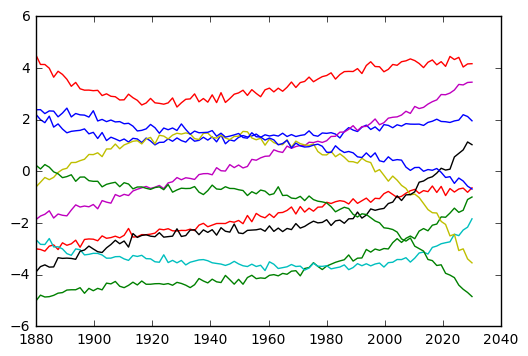

In [10]:
K = alpha*np.dot(Phi_pred, Phi_pred.T) + sigma2*np.eye(x_pred.size)
for i in range(10):
    y_sample = np.random.multivariate_normal(mean=np.zeros(x_pred.size), cov=K)
    plt.plot(x_pred.flatten(), y_sample.flatten())

where the effect of our noise term is to roughen the sampled functions, we can also increase the variance of the noise to see a different effect,

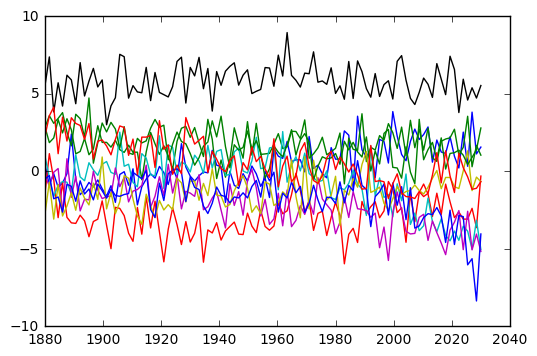

In [11]:
sigma2 = 1.
K = alpha*np.dot(Phi_pred, Phi_pred.T) + sigma2*np.eye(x_pred.size)
for i in range(10):
    y_sample = np.random.multivariate_normal(mean=np.zeros(x_pred.size), cov=K)
    plt.plot(x_pred.flatten(), y_sample.flatten())

### Function Space Reflection

How do you include the noise term when sampling in the weight space point of view?

## Gaussian Process

In our [session on Bayesian regression](./week7.ipynb) we sampled from the prior over paraemters. Through the properties of multivariate Gaussian densities this prior over parameters implies a particular density for our data observations, $\mathbf{y}$. In this session we sampled directly from this distribution for our data, avoiding the intermediate weight-space representation. This is the approach taken by *Gaussian processes*. In a Gaussian process you specify the *covariance function* directly, rather than *implicitly* through a basis matrix and a prior over parameters. Gaussian processes have the advantage that they can be *nonparametric*, which in simple terms means that they can have *infinite* basis functions. In the lectures we introduced the *exponentiated quadratic* covariance, also known as the RBF or the Gaussian or the squared exponential covariance function. This covariance function is specified by
$$
k(\mathbf{x}, \mathbf{x}^\prime) = \alpha \exp\left( -\frac{\left\Vert \mathbf{x}-\mathbf{x}^\prime\right\Vert^2}{2\ell^2}\right).
$$
where $\left\Vert\mathbf{x} - \mathbf{x}^\prime\right\Vert^2$ is the squared distance between the two input vectors 
$$
\left\Vert\mathbf{x} - \mathbf{x}^\prime\right\Vert^2 = (\mathbf{x} - \mathbf{x}^\prime)^\top (\mathbf{x} - \mathbf{x}^\prime) 
$$
Let's build a covariance matrix based on this function. First we define the form of the covariance function,

In [12]:
# %load -s exponentiated_quadratic mlai
def exponentiated_quadratic(x, x_prime, variance, lengthscale):
    squared_distance = ((x-x_prime)**2).sum()
    return variance*np.exp((-0.5*squared_distance)/lengthscale**2)        


We can use this to compute *directly* the covariance for $\mathbf{f}$ at the points given by `x_pred`. Let's define a new function `K()` which does this,

In [13]:
# %load -s compute_kernel mlai
def compute_kernel(X, X2, kernel, **kwargs):
    K = np.zeros((X.shape[0], X2.shape[0]))
    for i in np.arange(X.shape[0]):
        for j in np.arange(X2.shape[0]):
            K[i, j] = kernel(X[i, :], X2[j, :], **kwargs)
        
    return K


Now we can image the resulting covariance,

In [14]:
K = compute_kernel(x_pred, x_pred, exponentiated_quadratic, variance=1., lengthscale=10.)

To visualise the covariance between the points we can use the `imshow` function in matplotlib.

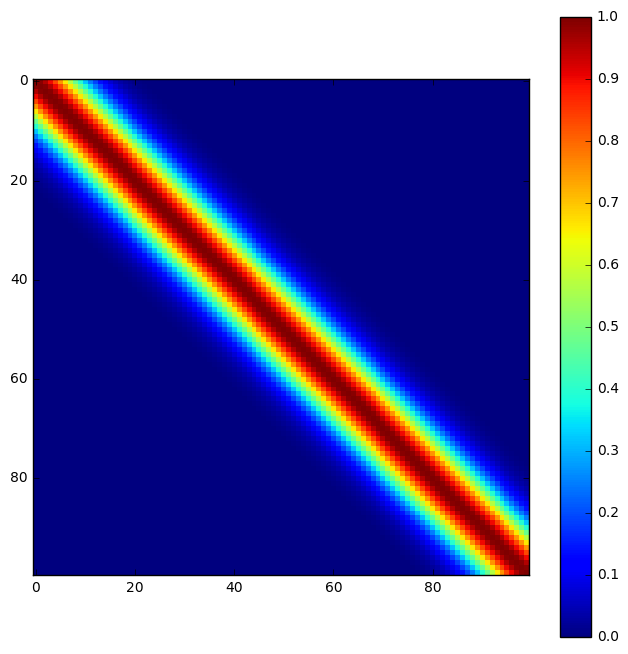

In [15]:
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(K, interpolation='none')
fig.colorbar(im)

Finally, we can sample functions from the marginal likelihood.

/Users/neil/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  from ipykernel import kernelapp as app


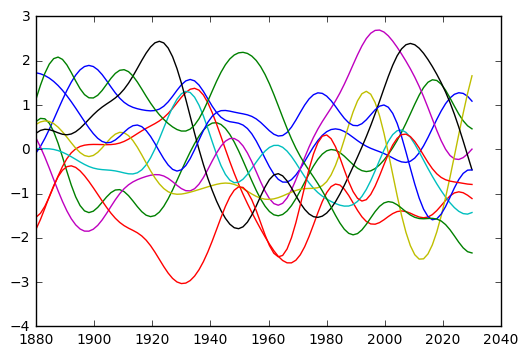

In [16]:
for i in range(10):
    y_sample = np.random.multivariate_normal(mean=np.zeros(x_pred.size), cov=K)
    plt.plot(x_pred.flatten(), y_sample.flatten())

### Exercise: Moving Parameters

Have a play with the parameters for this covariance function (the lengthscale and the variance) and see what effects the parameters have on the types of functions you observe.

## Gaussian Process

The Gaussian process perspective takes the marginal likelihood of the data to be a joint Gaussian density with a covariance given by $\mathbf{K}$. So the model likelihood is of the form,
$$
p(\mathbf{y}|\mathbf{X}) = \frac{1}{(2\pi)^{\frac{n}{2}}|\mathbf{K}|^{\frac{1}{2}}} \exp\left(-\frac{1}{2}\mathbf{y}^\top \left(\mathbf{K}+\sigma^2 \mathbf{I}\right)^{-1}\mathbf{y}\right)
$$
where the input data, $\mathbf{X}$, influences the density through the covariance matrix, $\mathbf{K}$ whose elements are computed through the covariance function, $k(\mathbf{x}, \mathbf{x}^\prime)$.

This means that the negative log likelihood (the objective function) is given by,
$$
E(\boldsymbol{\theta}) = \frac{1}{2} \log |\mathbf{K}| + \frac{1}{2} \mathbf{y}^\top \left(\mathbf{K} + \sigma^2\mathbf{I}\right)^{-1}\mathbf{y}
$$
where the *parameters* of the model are also embedded in the covariance function, they include the parameters of the kernel (such as lengthscale and variance), and the noise variance, $\sigma^2$.

Let's create a class in python for storing these variables.

In [17]:
# %load -s GP mlai.py
class GP():
    def __init__(self, X, y, sigma2, kernel, **kwargs):
        self.K = compute_kernel(X, X, kernel, **kwargs)
        self.X = X
        self.y = y
        self.sigma2 = sigma2
        self.kernel = kernel
        self.kernel_args = kwargs
        self.update_inverse()
    
    def update_inverse(self):
        # Preompute the inverse covariance and some quantities of interest
        ## NOTE: This is not the correct *numerical* way to compute this! It is for ease of use.
        self.Kinv = np.linalg.inv(self.K+self.sigma2*np.eye(self.K.shape[0]))
        # the log determinant of the covariance matrix.
        self.logdetK = np.linalg.det(self.K+self.sigma2*np.eye(self.K.shape[0]))
        # The matrix inner product of the inverse covariance
        self.Kinvy = np.dot(self.Kinv, self.y)
        self.yKinvy = (self.y*self.Kinvy).sum()

        
    def log_likelihood(self):
        # use the pre-computes to return the likelihood
        return -0.5*(self.K.shape[0]*np.log(2*np.pi) + self.logdetK + self.yKinvy)
    
    def objective(self):
        # use the pre-computes to return the objective function 
        return -self.log_likelihood()


## Making Predictions

We now have a probability density that represents functions. How do we make predictions with this density? The density is known as a process because it is *consistent*. By consistency, here, we mean that the model makes predictions for $\mathbf{f}$ that are unaffected by future values of $\mathbf{f}^*$ that are currently unobserved (such as test points). If we think of $\mathbf{f}^*$ as test points, we can still write down a joint probability density over the training observations, $\mathbf{f}$ and the test observations, $\mathbf{f}^*$. This joint probability density will be Gaussian, with a covariance matrix given by our covariance function, $k(\mathbf{x}_i, \mathbf{x}_j)$. 
$$
\begin{bmatrix}\mathbf{f} \\ \mathbf{f}^*\end{bmatrix} \sim \mathcal{N}\left(\mathbf{0}, \begin{bmatrix} \mathbf{K} & \mathbf{K}_\ast \\ \mathbf{K}_\ast^\top & \mathbf{K}_{\ast,\ast}\end{bmatrix}\right)
$$
where here $\mathbf{K}$ is the covariance computed between all the training points, $\mathbf{K}_\ast$ is the covariance matrix computed between the training points and the test points and $\mathbf{K}_{\ast,\ast}$ is the covariance matrix computed betwen all the tests points and themselves. To be clear, let's compute these now for our example, using `x` and `y` for the training data (although `y` doesn't enter the covariance) and `x_pred` as the test locations.

In [18]:
# set covariance function parameters
variance = 16.0
lengthscale = 8
# set noise variance
sigma2 = 0.05

K = compute_kernel(x, x, exponentiated_quadratic, variance=variance, lengthscale=lengthscale)
K_star = compute_kernel(x, x_pred, exponentiated_quadratic, variance=variance, lengthscale=lengthscale)
K_starstar = compute_kernel(x_pred, x_pred, exponentiated_quadratic, variance=variance, lengthscale=lengthscale)

Now we use this structure to visualise the covariance between test data and training data. This structure is how information is passed between trest and training data. Unlike the maximum likelihood formalisms we've been considering so far, the structure expresses *correlation* between our different data points. However, just like the [naive Bayes approach](./week9.ipynb) we now have a *joint density* between some variables of interest. In particular we have the joint density over $p(\mathbf{f}, \mathbf{f}^*)$. The joint density is *Gaussian* and *zero mean*. It is specified entirely by the *covariance matrix*, $\mathbf{K}$. That covariance matrix is, in turn, defined by a covariance function. Now we will visualise the form of that covariance in the form of the matrix,
$$
\begin{bmatrix} \mathbf{K} & \mathbf{K}_\ast \\ \mathbf{K}_\ast^\top & \mathbf{K}_{\ast,\ast}\end{bmatrix}
$$

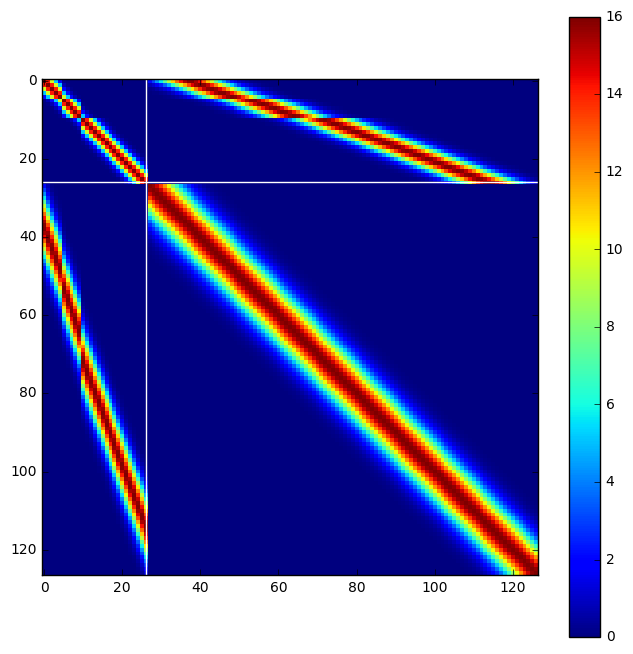

In [19]:
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(np.vstack([np.hstack([K, K_star]), np.hstack([K_star.T, K_starstar])]), interpolation='none')
# Add lines for separating training and test data
ax.axvline(x.shape[0]-1, color='w')
ax.axhline(x.shape[0]-1, color='w')
fig.colorbar(im)

There are four blocks to this color plot. The upper left block is the covariance of the training data with itself, $\mathbf{K}$. We see some structure here due to the missing data from the first and second world wars. Alongside this covariance (to the right and below) we see the cross covariance between the training and the test data ($\mathbf{K}_*$ and $\mathbf{K}_*^\top$). This is giving us the covariation between our training and our test data. Finally the lower right block The banded structure we now observe is because some of the training points are near to some of the test points. This is how we obtain 'communication' between our training data and our test data. If there is no structure in $\mathbf{K}_*$ then our belief about the test data simply matches our prior.

## Conditional Density

Just as in naive Bayes, we first defined the joint density (although there it was over both the labels and the inputs, $p(\mathbf{y}, \mathbf{X})$ and now we need to define *conditional* distributions that answer particular questions of interest. In particular we might be interested in finding out the values of the function for the prediction function at the test data given those at the training data, $p(\mathbf{f}_*|\mathbf{f})$. Or if we include noise in the training observations then we are interested in the conditional density for the prediction function at the test locations given the training observations, $p(\mathbf{f}^*|\mathbf{y})$. 

As ever all the various questions we could ask about this density can be answered using the *sum rule* and the *product rule*. For the multivariate normal density the mathematics involved is that of *linear algebra*, with a particular emphasis on the *partitioned inverse* or [*block matrix inverse*](http://en.wikipedia.org/wiki/Invertible_matrix#Blockwise_inversion), but they are beyond the scope of this course, so you don't need to worry about remembering them or rederiving them. We are simply writing them here because it is this *conditional* density that is necessary for making predictions.

The conditional density is also a multivariate normal,
$$
\mathbf{f}^* | \mathbf{f} \sim \mathcal{N}(\boldsymbol{\mu}_f,\mathbf{C}_f)
$$
with a mean given by
$$
\boldsymbol{\mu}_f = \mathbf{K}_*^\top \left[\mathbf{K} + \sigma^2 \mathbf{I}\right]^{-1} \mathbf{y}
$$
and a covariance given by 
$$
\mathbf{C}_f = \mathbf{K}_{*,*} - \mathbf{K}_*^\top \left[\mathbf{K} + \sigma^2 \mathbf{I}\right]^{-1} \mathbf{K}_\ast.
$$
Let's compute what those posterior predictions are for the olympic marathon data.

In [20]:
# %load -s posterior_f mlai
def posterior_f(self, X_test):
    K_star = compute_kernel(self.X, X_test, self.kernel, **self.kernel_args)
    A = np.dot(self.Kinv, K_star)
    mu_f = np.dot(A.T, y)
    C_f = K_starstar - np.dot(A.T, K_star)
    return mu_f, C_f


In [21]:
# attach the new method to class GP():
GP.posterior_f = posterior_f

In [22]:
model = GP(x, y, sigma2, exponentiated_quadratic, variance=variance, lengthscale=lengthscale)
mu_f, C_f = model.posterior_f(x_pred)


where for convenience we've defined

$$\mathbf{A} = \left[\mathbf{K} + \sigma^2\mathbf{I}\right]^{-1}\mathbf{K}_*.$$ 

We can visualize the covariance of the *conditional*,

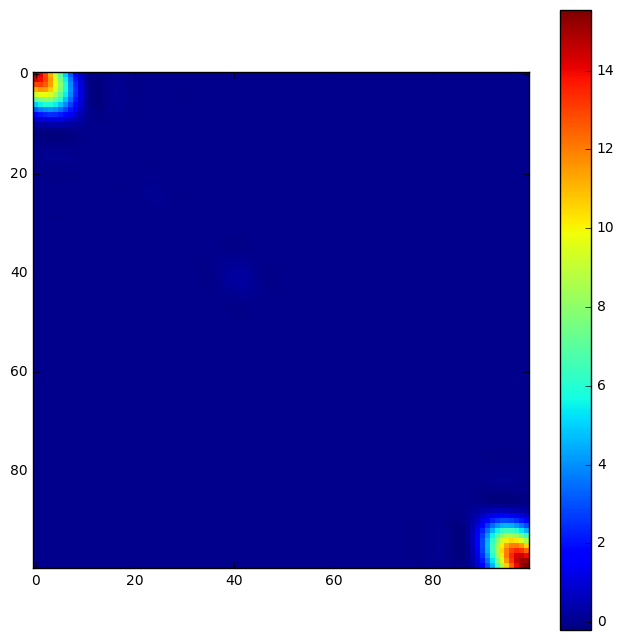

In [23]:
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(C_f, interpolation='none')
fig.colorbar(im)

and we can plot the mean of the conditional

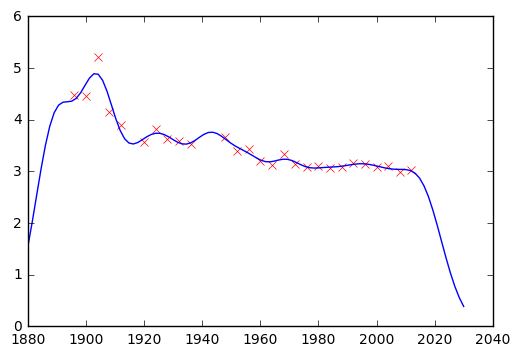

In [24]:
plt.plot(x, y, 'rx')
plt.plot(x_pred, mu_f, 'b-')

as well as the associated error bars. These are given (similarly to the Bayesian parametric model from the last lab) by the standard deviations of the marginal posterior densities. The marginal posterior variances are given by the diagonal elements of the posterior covariance,

In [25]:
var_f = np.diag(C_f)[:, None]
std_f = np.sqrt(var_f)

They can be added to the underlying mean function to give the error bars,

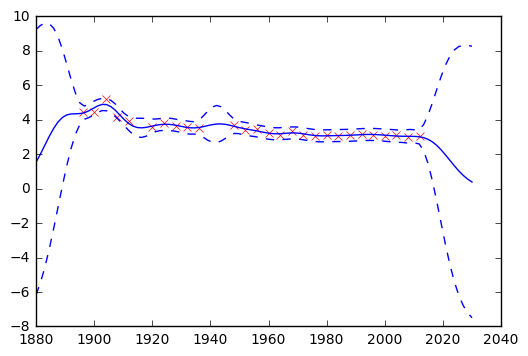

In [26]:
plt.plot(x, y, 'rx')
plt.plot(x_pred, mu_f, 'b-')
plt.plot(x_pred, mu_f+2*std_f, 'b--')
plt.plot(x_pred, mu_f-2*std_f, 'b--')

This gives us a prediction from the Gaussian process. Remember machine learning is 
$$
\text{data} + \text{model} \rightarrow \text{prediction}.
$$
Here our data is from the olympics, and our model is a Gaussian process with two parameters. The assumptions about the world are encoded entirely into our Gaussian process covariance. The GP covariance assumes that the function is highly smooth, and that correlation falls off with distance (scaled according to the length scale, $\ell$). The model sustains the uncertainty about the function, this means we see an increase in the size of the error bars during periods like the 1st and 2nd World Wars when no olympic marathon was held. 

## Exercises

Now try changing the parameters of the covariance function (and the noise) to see how the predictions change.

Now try sampling from this conditional density to see what your predictions look like. What happens if you sample from the conditional density in regions a long way into the future or the past? How does this compare with the results from the polynomial model?


## The Importance of the Covariance Function

The covariance function encapsulates our assumptions about the data. The equations for the distribution of the prediction function, given the training observations, are highly sensitive to the covariation between the test locations and the training locations as expressed by the matrix $\mathbf{K}_*$. We defined a matrix $\mathbf{A}$ which allowed us to express our conditional mean in the form,
$$
\boldsymbol{\mu}_f = \mathbf{A}^\top \mathbf{y},
$$
where $\mathbf{y}$ were our *training observations*. In other words our mean predictions are always a linear weighted combination of our *training data*. The weights are given by computing the covariation between the training and the test data ($\mathbf{K}_*$) and scaling it by the inverse covariance of the training data observations, $\left[\mathbf{K} + \sigma^2 \mathbf{I}\right]^{-1}$. This inverse is the main computational object that needs to be resolved for a Gaussian process. It has a computational burden which is $O(n^3)$ and a storage burden which is $O(n^2)$. This makes working with Gaussian processes computationally intensive for the situation where $n>10,000$.  

In [27]:
from IPython.display import YouTubeVideo
YouTubeVideo('ewJ3AxKclOg')

## Improving the Numerics

In practice we shouldn't be using matrix inverse directly to solve the GP system. One more stable way is to compute the *Cholesky decomposition* of the kernel matrix. The log determinant of the covariance can also be derived from the Cholesky decomposition.

In [28]:
# %load -s update_inverse mlai
def update_inverse(self):
    # Perform Cholesky decomposition on matrix
    self.R = sp.linalg.cholesky(self.K + self.sigma2*self.K.shape[0])
    # compute the log determinant from Cholesky decomposition
    self.logdetK = 2*np.log(np.diag(self.R)).sum()
    # compute y^\top K^{-1}y from Cholesky factor
    self.Rinvy = sp.linalg.solve_triangular(self.R, self.y)
    self.yKinvy = (self.Rinvy**2).sum()
    
    # compute the inverse of the upper triangular Cholesky factor
    self.Rinv = sp.linalg.solve_triangular(self.R, np.eye(self.K.shape[0]))
    self.Kinv = np.dot(self.Rinv, self.Rinv.T)


In [29]:
GP.update_inverse = update_inverse

## Capacity Control

Gaussian processes are sometimes seen as part of a wider family of methods known as kernel methods. Kernel methods are also based around covariance functions, but in the field they are known as Mercer kernels. Mercer kernels have interpretations as inner products in potentially infinite dimensional Hilbert spaces. This interpretation arises because, if we take $\alpha=1$, then the kernel can be expressed as
$$
\mathbf{K} = \boldsymbol{\Phi}\boldsymbol{\Phi}^\top 
$$
which imples the elements of the kernel are given by,
$$
k(\mathbf{x}, \mathbf{x}^\prime) = \boldsymbol{\phi}(\mathbf{x})^\top \boldsymbol{\phi}(\mathbf{x}^\prime).
$$
So we see that the kernel function is developed from an inner product between the basis functions. Mercer's theorem tells us that any valid *positive definite function* can be expressed as this inner product but with the caveat that the inner product could be *infinite length*. This idea has been used quite widely to *kernelize* algorithms that depend on inner products. The kernel functions are equivalent to covariance functions and they are parameterized accordingly. In the kernel modeling community it is generally accepted that kernel parameter estimation is a difficult problem and the normal solution is to cross validate to obtain parameters. This can cause difficulties when a large number of kernel parameters need to be estimated. In Gaussian process modelling kernel parameter estimation (in the simplest case proceeds) by maximum likelihood. This involves taking gradients of the likelihood with respect to the parameters of the covariance function. 

## Gradients of the Likelihood

The easiest conceptual way to obtain the gradients is a two step process. The first step involves taking the gradient of the likelihood with respect to the covariance function, the second step involves considering the gradient of the covariance function with respect to its parameters.

## Overall Process Scale

In general we won't be able to find parameters of the covariance function through fixed point equations, we will need to do gradient based optimization.

## Capacity Control and Data Fit

The objective function can be decomposed into two terms, a capacity control term, and a data fit term. The capacity control term is the log determinant of the covariance. The data fit term is the matrix inner product between the data and the inverse covariance.